In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
from itertools import product
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier, plot_tree
from joblib import dump, load
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    auc,
    roc_curve,
    f1_score,
    fbeta_score,
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import balanced_accuracy_score


# Make all plots pretty big
plt.rcParams["figure.figsize"] = [20, 12]

# The warnings around pandas are annoying - none are relevant but would
# be worth looking at if this was more than a notebook
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

In [2]:
# Use data_connector.py to generate this file
df = pd.read_csv("all_data_fix.csv")

In [3]:
# Start just with the most failed tests, memorization and risky rows
# The _PASS columns are just the binary outcome of the test - without the _PASS its the raw test value
df = df.drop(
    columns=[
        "PRIVACY_Minimum row count",
        "PRIVACY_No new categorical values",
        "PRIVACY_Check distance distributions between real and synthetic",
        "PRIVACY_Membership inference",
        "PRIVACY_Attribute inference",
        # "table_name",
    ]
)
df = df.drop(
    columns=[
        "PRIVACY_Minimum row count_PASS",
        "PRIVACY_No new categorical values_PASS",
        "PRIVACY_Check distance distributions between real and synthetic_PASS",
        "PRIVACY_Membership inference_PASS",
        "PRIVACY_Attribute inference_PASS",
    ]
)


# Split these into targets for classification and regression
privacy_cols_numeric = [
    col for col in df.columns if "PRIVACY" in col and "PASS" not in col
]
privacy_cols_bin = [col for col in df.columns if "PRIVACY" in col and "PASS" in col]

# The risky row count is inherently influenced by the overall row count and from a privacy POV, we care about the proportion of risky rows
# This transform here makes it easier to use than to use row count as a feature and then dealing with interactions and such
df["PRIVACY_Risky row counts"] = df["PRIVACY_Risky row counts"] / df["row_count"]

In [4]:
# We need some variance in all targets (things that pass and fail)
print(df[privacy_cols_numeric].nunique())
print(df[privacy_cols_bin].nunique())

PRIVACY_Risky row counts    163
PRIVACY_Row memorization     46
dtype: int64
PRIVACY_Risky row counts_PASS    2
PRIVACY_Row memorization_PASS    2
dtype: int64


In [5]:
# Lots of helper functions! See docstrings for rationale


def add_interactions(X, num_interactions: int, custom_interactions: list):
    """
    Create interaction terms for X.
    An interaction is the product of two columns - this can help capture non-linear relationships between features
    This is only useful for models that won't inherently capture these interactions (like linear models)
    For example, a tree based model doesn't need these interactions because it can split two separate nodes on different features
    which would capture the interaction

    The point of interaction terms is to use a simpler model that can be more interpretable and still capture the relationships between features

    Inputs:
    - num_interactions: The number of features per interaction. For example, if num_interactions = 2, we will create interactions between all pairs of features
    - custom_interactions: A list of columns to create interactions with all other columns in X. Only use this if num_interactions=1 and you are trying to only create interactions with specific columns
        If num_interactions > 1, this will be a no-op since the interactions would already be captured
    """
    if num_interactions > 1:
        for comb in list(product(X.columns, repeat=num_interactions)):
            X[f"{comb[0]}_x_{comb[1]}"] = X[comb[0]] * X[comb[1]]

    for col in custom_interactions:
        for other_col in X.columns:
            if f"{col}_x_{other_col}" not in X.columns:  # Dont remake existing columns
                if (
                    not "type" in col and "type" in other_col
                ):  # Dont create interactions between model types because they are just OHE vars
                    if (
                        "_x_" not in col and "_x_" not in other_col
                    ):  # Dont create interactions between interactions
                        X[f"{col}_x_{other_col}"] = X[col] * X[other_col]
    return X


def prepare_data(
    df,
    num_interactions: int,
    ignore_0: bool,
    custom_interactions: list,
    ignore_cols: list,
    target: str,
):
    """
    Setup data for the model. This takes the entire dataset and splits it into X/y and applies some custom logic to:
        - Drop some specific columns
            - Anything you explicitly say to drop in ignore_cols
            - Anything with nulls (for simplicity)
            - Anything with infinite values (for simplicity)
            - The privacy columns (since they are the targets for other models)
        - Filter out some rows if necessary
            - Specifically you can make ignore_0=True to drop all rows where the target is 0. The reason for this is there is a sort of tweedie distribution in the targets
             which throws off more basic linear models. I'd expect more data would make this less of an issue as I doubt more complex data would end up with score of purely 0
        - One hot encode the model type
    """
    df = df.copy()

    # Use all but the other privacy columns as features
    # Also remove any columns with missing values or that contain an infinite value
    # Drop all columns that we explicitly ignore columns
    features = [
        c
        for c in df.columns
        if c not in privacy_cols_numeric
        and c not in privacy_cols_bin
        and c not in ignore_cols
        and c != target
        and df[c].isna().sum() == 0
        and not df[c].isin([float("inf"), -float("inf")]).any()
    ]

    X = df[features]
    X = pd.get_dummies(X, columns=["type"])  # One hot encode the model type
    X = add_interactions(
        X, num_interactions=num_interactions, custom_interactions=custom_interactions
    )
    y = df[target]

    # Drop the rows where the target is 0 if necessary
    if ignore_0:
        X = X[y != 0]
        y = y[y != 0]

    return X, y


def fit_tree(X_train, y_train):
    """Fit a decision tree to the data"""
    tree = DecisionTreeClassifier(**TREE_ARGS).fit(X_train, y_train)

    return tree


def fit_ols(X_train, y_train, fit_intercept: bool = False, print_summary: bool = False):
    """
    Fit a linear regression model to the data with an optional intercept
    """
    if fit_intercept:  # Add intercept if requested
        X_train = sm.add_constant(X_train)

    model = sm.OLS(y_train, X_train).fit()

    return model


def plot_predictions_with_confidence(model, X, y, fig=None):
    """
    Given a model and data, plot the actual vs predicted values with 95% confidence intervals lined up.
    You can repeatedly use this function to add more lines to the plot if you pass in the fig object from the
    previous call
    """
    # Get predictions and prediction intervals
    pred_results = model.get_prediction(X)
    y_pred = pred_results.predicted_mean  # Predicted values
    conf_int = pred_results.conf_int(alpha=0.05)  # 95% CI

    conf_int_lower = conf_int[:, 0]
    conf_int_upper = conf_int[:, 1]

    # Create the figure if not there - we will add to it if it is
    if fig is None:
        fig = go.Figure()

    # Dots
    fig.add_trace(
        go.Scatter(
            x=y,
            y=y_pred,
            mode="markers",
            name="Predicted values",
            marker=dict(color="blue", opacity=0.7),
        )
    )

    # CI Lines
    for i in range(len(y)):
        fig.add_trace(
            go.Scatter(
                x=[y.iloc[i], y.iloc[i]],  # Actual value for the x-axis
                y=[
                    conf_int_lower[i],
                    conf_int_upper[i],
                ],  # Confidence interval for the y-axis
                mode="lines",
                line=dict(color="gray", width=2, dash="dot"),
                showlegend=False,
            )
        )

    fig.update_layout(
        title="Actual vs Predicted with 95% Confidence Intervals",
        xaxis_title="Actual values",
        yaxis_title="Predicted values",
        hovermode="closest",
    )

    fig.update_xaxes(range=[-0.5, 0.5])
    fig.update_yaxes(range=[-0.5, 0.5])

    return fig


def cross_validate_tree(model, X, y, cv_splits=3):
    """
    Run a cross validation on a given model to get the average AUC score
    """
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=41)

    auc_scores = cross_val_score(model, X, y, cv=kf, scoring="roc_auc")
    return np.mean(auc_scores)


def cross_validate_ols(X, y, cv_splits=3):
    """
    Run a cross validation on a linear regression model to get the average absolute percentage error
    """
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Add constant term for the intercept
        if FIT_INTERCEPT:
            X_train = sm.add_constant(X_train)
            X_val = sm.add_constant(X_val)

        # Fit OLS model
        model = sm.OLS(y_train, X_train).fit()

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate R-squared and mape
        mape = mean_absolute_percentage_error(y_val, y_pred)

        mape_scores.append(mape)

    return np.mean(mape_scores)

In [6]:
# Some default globals - you could move these to the top of the file if you wanted to make them clearer and fix VSCode linting
# I put them here so you first see the functionality they impact


# Features to drop - manually messing with the model to see what works

# Since there are relatively few tables in the input data, a lot of these features end up just being proxies
# for the input table which creates a lot of data leakage
IGNORE = [
    # column
    # for column in df.columns
    # if column.startswith("std")
    # or column.startswith("max")  # or column.startswith("num")
    # or column.startswith("pct")
    # or column.startswith("avg")
]
IGNORE.extend(
    [
        # "num_equivalence_classes",
        "table_name",
        # "avg_indirect_id_unique_values",
        # "median_equivalence_class_size",
        # "row_count",
        # "pct_indirect_ids",
        # "avg_equivalence_class_size",
    ]
)

# Model features are not useful since theres really no variance in them
IGNORE.extend(["batch_size", "epochs", "learning_rate"])

PRINT_SUMMARY = True
NUM_INTERACTIONS = (
    2  # The data isn't perfectly linear so we need some interaction terms
)
ALLOW_0 = True  # The 0's really throw off the linear model and make it hard to interpret - this would be a place to improve in the future
FIT_INTERCEPT = False  # In this case an intercept probably doesn't make a ton of sense because theoretically the default privacy score would be 0
TREE_ARGS = {
    "max_depth": 2,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
}  # Arguments to pass to the tree model, just some basic ones to prevent overfitting

CUSTOM_INTERACTIONS = (
    []
)  # Experimented with this instead of NUM_INTERACTIONS but didnt bear fruit

In [7]:
# load the test table from txt file
with open("test_set.txt") as f:
    test_tables = f.read().splitlines()

df_test = df[df["table_name"].isin(test_tables)]

df_test.shape

(58, 31)

In [8]:
df_train = df[~df["table_name"].isin(test_tables)]
df_train.shape

(233, 31)

============================== PRIVACY_Risky row counts, feature selection mode: man =====================================
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}
Train Accuracy score: 0.8548387096774194
Train Balanced accuracy score: 0.8870967741935484
Validattion Accuracy score: 0.8723404255319149
Valication Balanced accuracy score: 0.9230769230769231


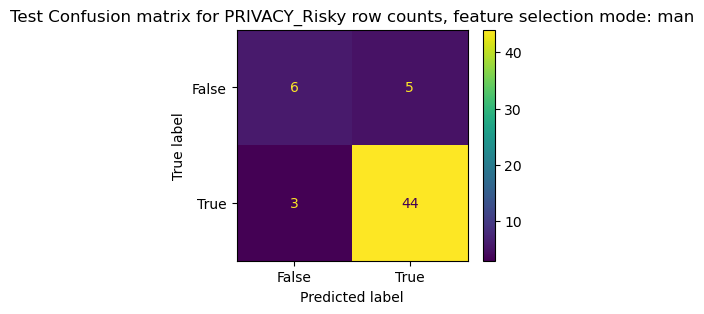

TEST Accuracy score: 0.8620689655172413
TEST Balanced accuracy score: 0.7408123791102514
TEST F0.5 score for PRIVACY_Risky row counts_PASS: 0.9053497942386831
TEST Classification report:
              precision    recall  f1-score   support

       False       0.67      0.55      0.60        11
        True       0.90      0.94      0.92        47

    accuracy                           0.86        58
   macro avg       0.78      0.74      0.76        58
weighted avg       0.85      0.86      0.86        58

============================== PRIVACY_Risky row counts, feature selection mode: fw =====================================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'gini'}
Train Accuracy score: 0.8010752688172043
Train Balanced accuracy score: 0.8677419354838709
Validattion Accuracy score: 0.8723404255319149
Valication Balanced accuracy score: 0.923076923076923

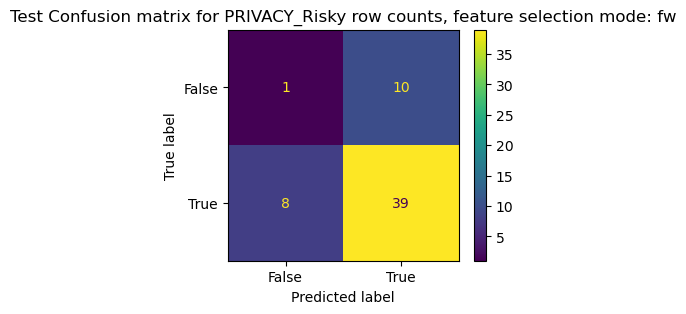

TEST Accuracy score: 0.6896551724137931
TEST Balanced accuracy score: 0.46034816247582205
TEST F0.5 score for PRIVACY_Risky row counts_PASS: 0.8024691358024691
TEST Classification report:
              precision    recall  f1-score   support

       False       0.11      0.09      0.10        11
        True       0.80      0.83      0.81        47

    accuracy                           0.69        58
   macro avg       0.45      0.46      0.46        58
weighted avg       0.67      0.69      0.68        58

============================== PRIVACY_Row memorization, feature selection mode: man =====================================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}
Train Accuracy score: 0.918918918918919
Train Balanced accuracy score: 0.9558823529411764
Validattion Accuracy score: 0.9473684210526315
Valication Balanced accuracy score: 0.97142857142

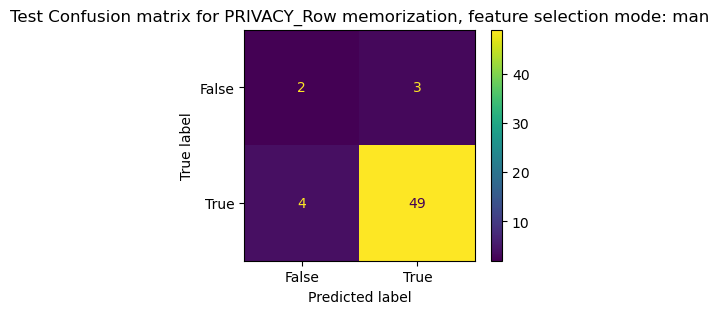

TEST Accuracy score: 0.8793103448275862
TEST Balanced accuracy score: 0.6622641509433962
TEST F0.5 score for PRIVACY_Row memorization_PASS: 0.9386973180076628
TEST Classification report:
              precision    recall  f1-score   support

       False       0.33      0.40      0.36         5
        True       0.94      0.92      0.93        53

    accuracy                           0.88        58
   macro avg       0.64      0.66      0.65        58
weighted avg       0.89      0.88      0.88        58

============================== PRIVACY_Row memorization, feature selection mode: fw =====================================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'log_loss'}
Train Accuracy score: 0.918918918918919
Train Balanced accuracy score: 0.9558823529411764
Validattion Accuracy score: 0.9473684210526315
Valication Balanced accuracy score: 0.971428571428

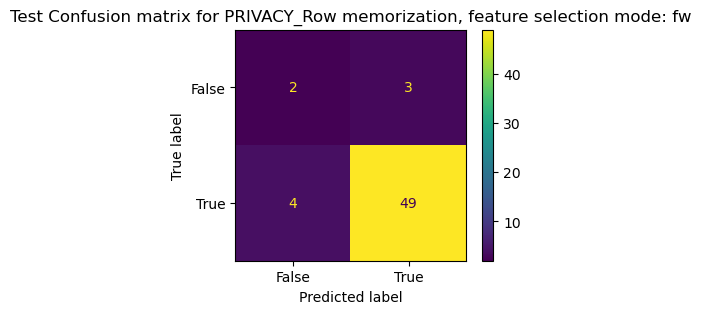

TEST Accuracy score: 0.8793103448275862
TEST Balanced accuracy score: 0.6622641509433962
TEST F0.5 score for PRIVACY_Row memorization_PASS: 0.9386973180076628
TEST Classification report:
              precision    recall  f1-score   support

       False       0.33      0.40      0.36         5
        True       0.94      0.92      0.93        53

    accuracy                           0.88        58
   macro avg       0.64      0.66      0.65        58
weighted avg       0.89      0.88      0.88        58



In [9]:
from perf import evaluate_model

for target in privacy_cols_numeric:
    binary_target = target + "_PASS"

    # print(f"\t\t WORKING ON TARGET: {target} and {binary_target}")

    # Prepare data for both continuous and binary targets
    df_train, df_val = train_test_split(
        df_train, test_size=0.2, random_state=42, stratify=df_train[binary_target]
    )

    feature_mode = ["man", "fw"]

    for mode in feature_mode:
        print(
            f"============================== {target}, feature selection mode: {mode} ====================================="
        )

        X_train, y_train = prepare_data(
            df_train,
            num_interactions=1,
            ignore_0=False,
            custom_interactions=[],
            ignore_cols=IGNORE,
            target=binary_target,
        )
        X_test, y_test = prepare_data(
            df_test,
            num_interactions=1,
            ignore_0=False,
            custom_interactions=[],
            ignore_cols=IGNORE,
            target=binary_target,
        )
        X_val, y_val = prepare_data(
            df_val,
            num_interactions=1,
            ignore_0=False,
            custom_interactions=[],
            ignore_cols=IGNORE,
            target=binary_target,
        )

        # load the selected features from the txt file
        with open(f"{target}_selected_features_{mode}.txt", "r") as f:
            selected_features = f.read().splitlines()
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        X_val = X_val[selected_features]

        # Standardize numerical features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val = scaler.transform(X_val)
        param_dist = {
            # "max_depth": np.arange(2, 20, 1),
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 10, 2),
            "max_features": ["sqrt", "log2"],
            "criterion": ["gini", "entropy", "log_loss"],
        }

        # Initialize the model
        dt = DecisionTreeClassifier(
            random_state=42, class_weight="balanced", max_depth=5
        )

        # Use Stratified K-Fold Cross-Validation to prevent overfitting
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform Randomized Search
        random_search = RandomizedSearchCV(
            dt,
            param_distributions=param_dist,
            n_iter=50,  # Number of random samples
            cv=cv,  # Cross-validation strategy
            scoring="balanced_accuracy",  # Optimize for accuracy
            n_jobs=-1,  # Use all CPU cores
            verbose=1,
            random_state=42,
        )

        random_search.fit(X_train, y_train)

        # Get the best parameters
        best_params = random_search.best_params_
        print("Best Parameters:", best_params)

        # Train the best model
        best_dt = random_search.best_estimator_

        y_pred_train = best_dt.predict(X_train)
        print(f"Train Accuracy score: {accuracy_score(y_train, y_pred_train)}")
        print(
            f"Train Balanced accuracy score: {balanced_accuracy_score(y_train, y_pred_train)}"
        )

        # get the accuracy for validation set
        y_pred_val = best_dt.predict(X_val)
        print(f"Validattion Accuracy score: {accuracy_score(y_val, y_pred_val)}")
        print(
            f"Valication Balanced accuracy score: {balanced_accuracy_score(y_val, y_pred_val)}"
        )

        y_pred = best_dt.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=best_dt.classes_)

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=best_dt.classes_
        )
        fig, ax = plt.subplots(figsize=(4, 3))
        disp.plot(ax=ax)
        plt.title(f"Test Confusion matrix for {target}, feature selection mode: {mode}")
        plt.show()
        print(f"TEST Accuracy score: {accuracy_score(y_test, y_pred)}")
        print(
            f"TEST Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred)}"
        )
        print(
            f"TEST F0.5 score for {binary_target}: {fbeta_score(y_test, y_pred, beta=0.5)}"
        )
        print(f"TEST Classification report:")
        print(classification_report(y_test, y_pred))
        evaluate_model(best_dt, X_test, y_test, str(target), "dt", str(mode))